#  **Практическое занятие №6. Компьютерное зрение. Свёрточные нейронные сети.**

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## CIFAR 10

In [2]:
from torchvision.datasets import CIFAR10
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize

cifar_transform = Compose([
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

cifar = CIFAR10(root='cifar', download=True, train=True, transform=cifar_transform)

cifar_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:16<00:00, 10550642.14it/s]


Extracting cifar\cifar-10-python.tar.gz to cifar


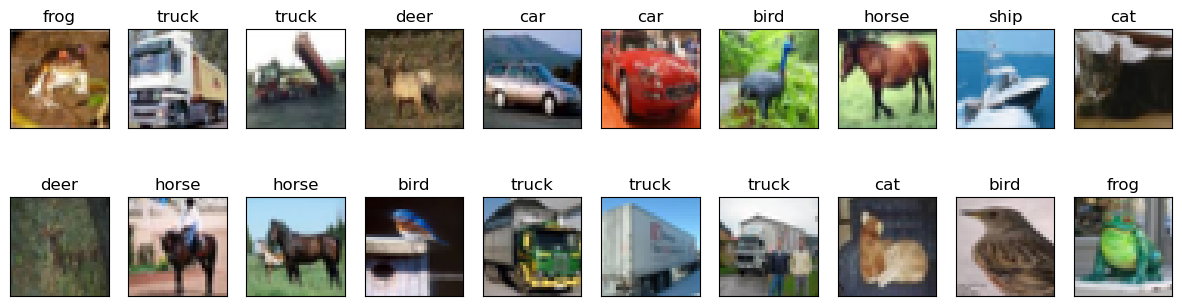

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(cifar[i][0].permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(cifar_names[cifar[i][1]])

plt.show()

In [4]:
from torch.utils.data import random_split

train_set, valid_set = random_split(cifar, (0.95, 0.05))

## Simple network

In [5]:
# build model

from torch import nn
from torchsummary import summary

model = nn.Sequential(
    nn.Flatten(start_dim=-3),
    nn.Linear(in_features=3072, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
    nn.Sigmoid()
).to(device)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 512]       1,573,376
              ReLU-3                  [-1, 512]               0
            Linear-4                   [-1, 64]          32,832
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
           Sigmoid-7                   [-1, 10]               0
Total params: 1,606,858
Trainable params: 1,606,858
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 6.13
Estimated Total Size (MB): 6.17
----------------------------------------------------------------


In [6]:
# prepare

from torch.utils.data import DataLoader

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=8)
valid_loader = DataLoader(valid_set, batch_size=8)

In [ ]:
# train model

Можно снизить количество бойлерплейта и сделать код более структурированным за счет использования дополнительных библиотек

## PyTorch Ignite

See https://pytorch-ignite.ai

See https://pytorch-ignite.ai/tutorials/beginner/01-getting-started

In [8]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 5.6 MB/s eta 0:00:00


In [7]:
# create trainer and evaluators

from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

trainer = create_supervised_trainer(model, optimizer, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [8]:
# add logging

from ignite.engine import Events

def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output}")

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=1000), log_iter_loss)

def compute_epoch_results(engine):
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

def log_epoch_results(engine, label=""):
    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    print(f"{label} Res:", result)

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")

In [9]:
# add lr scheduler

from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, print_lr)

In [10]:
# run training loop

trainer.run(train_loader, 2)

Epoch[1] - Iter[1000]: loss = 2.3022420406341553
Epoch[1] - Iter[2000]: loss = 2.2558276653289795
Epoch[1] - Iter[3000]: loss = 2.2384889125823975
Epoch[1] - Iter[4000]: loss = 2.2015957832336426
Epoch[1] - Iter[5000]: loss = 2.121382474899292
Train Res: accuracy = 0.26602105263157894, loss = 2.1841888157894735
Valid Res: accuracy = 0.2552, loss = 2.1866953125
Optimizer learning rate = 0.001
Epoch[2] - Iter[6000]: loss = 2.047513723373413
Epoch[2] - Iter[7000]: loss = 2.264411449432373
Epoch[2] - Iter[8000]: loss = 2.1765518188476562
Epoch[2] - Iter[9000]: loss = 2.1083085536956787
Epoch[2] - Iter[10000]: loss = 2.064969539642334
Epoch[2] - Iter[11000]: loss = 1.997533917427063
Train Res: accuracy = 0.3080631578947368, loss = 2.1040720394736843
Valid Res: accuracy = 0.3032, loss = 2.106071875
Optimizer learning rate = 0.001


State:
	iteration: 11876
	epoch: 2
	epoch_length: 5938
	max_epochs: 2
	output: 1.9947969913482666
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

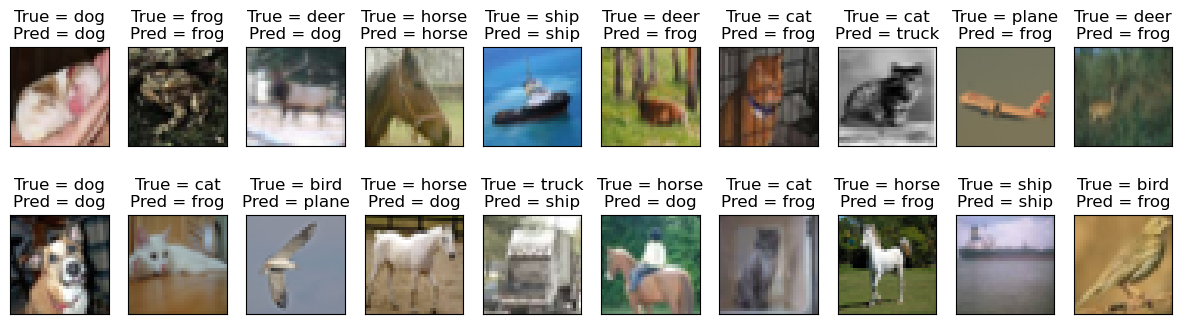

In [11]:
model.eval()

plt.figure(figsize=(15,4))

for i in range(20):
    x, y_true = valid_set[i]
    y_pred = torch.argmax(model(x.to(device)))
    plt.subplot(2, 10, i + 1)
    plt.imshow(x.permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'True = {cifar_names[y_true]}\nPred = {cifar_names[y_pred]}')

plt.show()

## Convolutional network

See https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

See https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d

In [13]:
cifar[0][0].shape

torch.Size([3, 32, 32])

In [16]:
model = nn.Sequential(

    nn.Conv2d(3, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),   # out shape = (16, 14, 14), params count = ?

    nn.Conv2d(16, 64, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),   # out shape = (64, 5, 5), params count = ?

    nn.Conv2d(64, 256, 5),
    nn.ReLU(),            # out shape = (256, 1, 1), params count = ?

    nn.Flatten(-3),
    nn.Linear(64 * 5 * 5, 64),
    nn.ReLU(),
    nn.Linear(64, 10)

).to(device)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 64, 10, 10]          25,664
              ReLU-5           [-1, 64, 10, 10]               0
         MaxPool2d-6             [-1, 64, 5, 5]               0
            Conv2d-7            [-1, 256, 1, 1]         409,856
              ReLU-8            [-1, 256, 1, 1]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                   [-1, 64]          16,448
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 453,834
Trainable params: 453,834
Non-trainable params: 0
-------------------------------

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=8)
valid_loader = DataLoader(valid_set, batch_size=8)

trainer = create_supervised_trainer(model, optimizer, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=1000), log_iter_loss)
trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)
train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")

In [18]:
trainer.run(train_loader, 2)

Epoch[1] - Iter[1000]: loss = 2.0356671810150146
Epoch[1] - Iter[2000]: loss = 1.5849089622497559
Epoch[1] - Iter[3000]: loss = 1.2407658100128174
Epoch[1] - Iter[4000]: loss = 1.483937382698059
Epoch[1] - Iter[5000]: loss = 1.452030897140503
Train Res: accuracy = 0.5374105263157894, loss = 1.282172697368421
Valid Res: accuracy = 0.5372, loss = 1.268467578125
Epoch[2] - Iter[6000]: loss = 1.3298962116241455
Epoch[2] - Iter[7000]: loss = 0.7804383039474487
Epoch[2] - Iter[8000]: loss = 1.156557559967041
Epoch[2] - Iter[9000]: loss = 0.6427172422409058
Epoch[2] - Iter[10000]: loss = 0.9273169636726379
Epoch[2] - Iter[11000]: loss = 1.6175954341888428
Train Res: accuracy = 0.6386105263157895, loss = 1.0307578125
Valid Res: accuracy = 0.6176, loss = 1.0825869140625


State:
	iteration: 11876
	epoch: 2
	epoch_length: 5938
	max_epochs: 2
	output: 1.5183923244476318
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

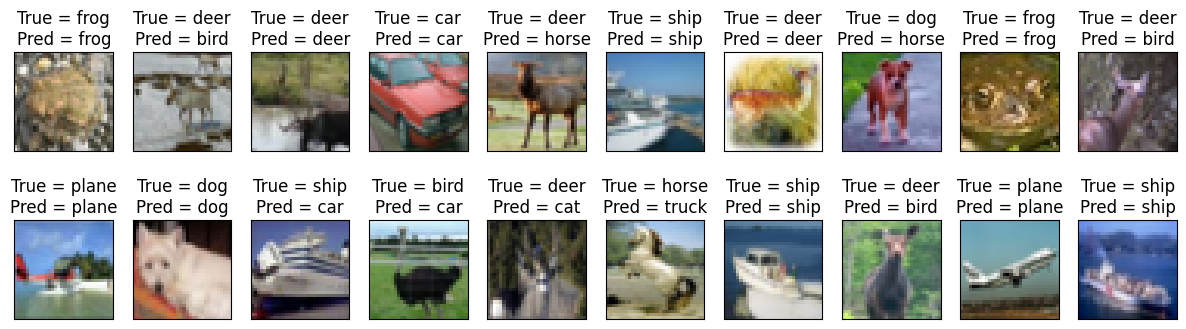

In [19]:
model.eval()

plt.figure(figsize=(15,4))

for i in range(20):
    x, y_true = valid_set[i]
    y_pred = torch.argmax(model(x.to(device)))
    plt.subplot(2, 10, i + 1)
    plt.imshow(x.permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'True = {cifar_names[y_true]}\nPred = {cifar_names[y_pred]}')

plt.show()

## Additionals

### Data Augmentation

See https://pytorch.org/vision/main/transforms.html

In [22]:
from torchvision.transforms.v2 import RandomHorizontalFlip

cifar_transform_flip = Compose([
    RandomHorizontalFlip(1.0),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

cifar_flip = CIFAR10(root='cifar', download=True, train=True, transform=cifar_transform_flip)

Files already downloaded and verified


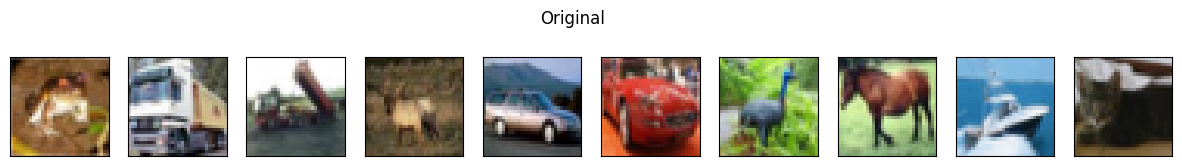

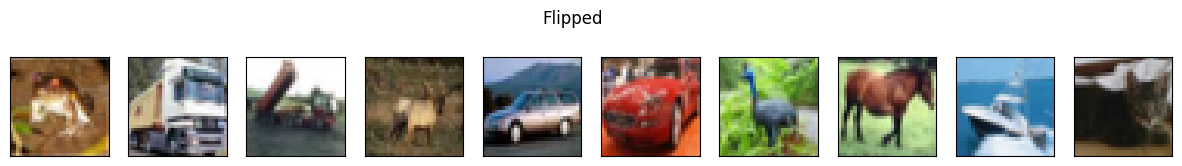

In [23]:
plt.figure(figsize=(15,2))
plt.suptitle("Original")

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(cifar[i][0].permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])


plt.figure(figsize=(15,2))
plt.suptitle("Flipped")

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(cifar_flip[i][0].permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])


plt.show()

### Ignite utilities

Adding checkpoints - https://pytorch.org/ignite/generated/ignite.handlers.checkpoint.ModelCheckpoint.html#modelcheckpoint

Pretty loggers - https://pytorch-ignite.ai/how-to-guides/10-loggers